# **Image Stitching**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

**Image Stitching** is a computer vision technique that involves combining multiple images with overlapping fields of views to create a panaromic or wide-angle image.

<span style="color:red; font-weight:bold">I'll try to re-enact an average implementation of image stitching. I recommend you go with the code in the professor's notebook or in homework 2. This is just to explain the main concepts.</span>

**Procedure for Image Stitching Given Two Images A and B**

**Step 1**: Choose one of the two images as a reference. For example, we'll choose A to be the reference image and B as the source image. Meaning, we'll transform (as in translate/rotate/scale/shear/project etc...) the source image (B) so the corresponding components of both images align with one another.<br>
**Step 2**: Compute the keypoints and descriptors for the reference and source images.<br>
**Step 3**: Find the matches between the descriptors of the source and reference images.<br>
**Step 4**: Compute the Homography Matrix that will transform the source image (B) such that it aligns with the reference image (A). Thereafter, apply this Homography matrix to the source image (B) to obtained the transformed source image (B')<br>
**Step 5**: Display a new image that concatenates the reference image (A) and the transformed source image (B').

---

**Step 1: Choose one of the two images as a reference. For example, we'll choose A to be the reference image and B as the source image. Meaning, we'll transform (as in translate/rotate/scale/shear/project etc...) the source image (B) so the corresponding components of both images align with one another.**

Let's begin by reading in the two images that we'll have to stitch. For this example, I'll take the image on the left as the reference image, and the image on the right as the source image.

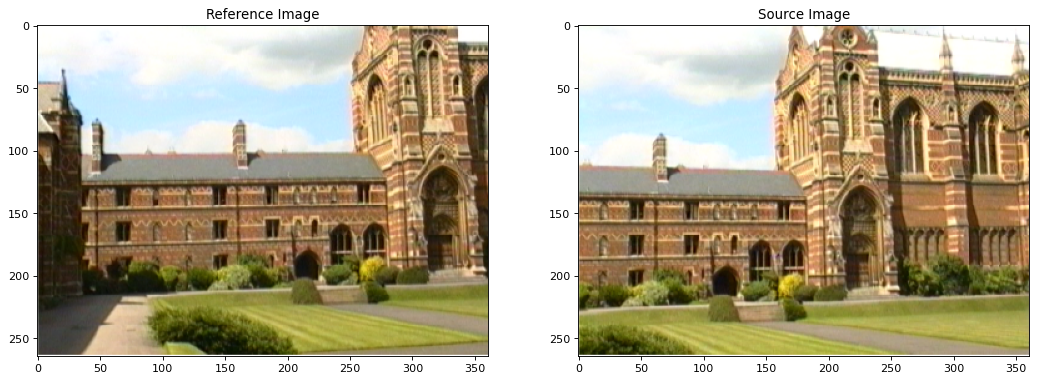

In [2]:
img_reference = cv2.imread('data/images/left-image.png')
img_reference = cv2.cvtColor(img_reference, cv2.COLOR_BGR2RGB)

img_source = cv2.imread('data/images/right-image.png')
img_source = cv2.cvtColor(img_source, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (16, 9))

plt.subplot(121)
plt.title("Reference Image")
plt.imshow(img_reference)

plt.subplot(122)
plt.title("Source Image")
plt.imshow(img_source);

**Step 2: Compute the keypoints and descriptors for the reference and source images.**

In [3]:
detector = cv2.SIFT_create()

img_reference_keypoints, img_reference_descriptors = detector.detectAndCompute(img_reference, None)
img_source_keypoints, img_source_descriptors = detector.detectAndCompute(img_source, None)

Additionally, Let's display the keyoints.

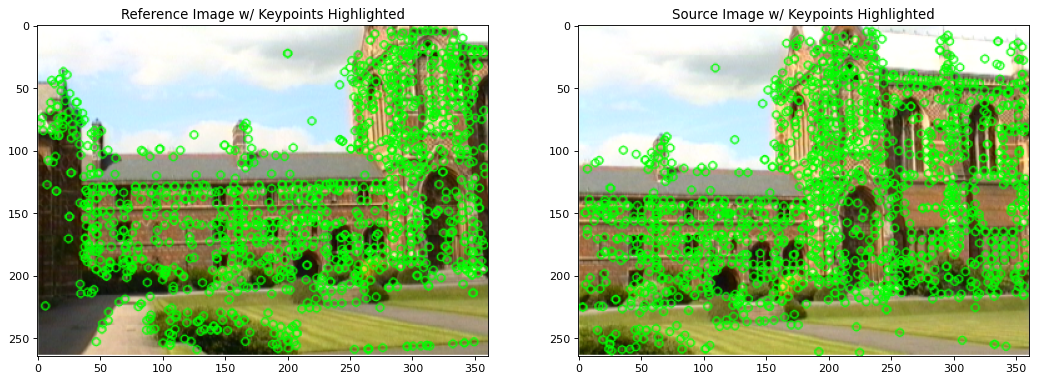

In [4]:
img_reference_with_keypoints = cv2.drawKeypoints(
                            image = img_reference, 
                            keypoints = img_reference_keypoints, 
                            outImage = None, 
                            color = (0, 255, 0), 
                            flags = cv2.DRAW_MATCHES_FLAGS_DEFAULT
)

img_source_with_keypoints = cv2.drawKeypoints(
                            image = img_source, 
                            keypoints = img_source_keypoints, 
                            outImage = None, 
                            color = (0, 255, 0), 
                            flags = cv2.DRAW_MATCHES_FLAGS_DEFAULT
)

plt.figure(figsize = (16, 9))

plt.subplot(121)
plt.title("Reference Image w/ Keypoints Highlighted")
plt.imshow(img_reference_with_keypoints)

plt.subplot(122)
plt.title("Source Image w/ Keypoints Highlighted")
plt.imshow(img_source_with_keypoints);

**Step 3: Find the matches between the descriptors of the source and reference images.**

For the matching, I'll go ahead with the KNN and Ratio Test technique. 

In [5]:
bf = cv2.BFMatcher()

matches = bf.knnMatch(img_reference_descriptors, img_source_descriptors, k = 2)

good_matches = []

for match_1, match_2 in matches:
    if match_1.distance < 0.75 * match_2.distance:
        good_matches.append(match_1)

Let's go ahead and draw the matches as well.

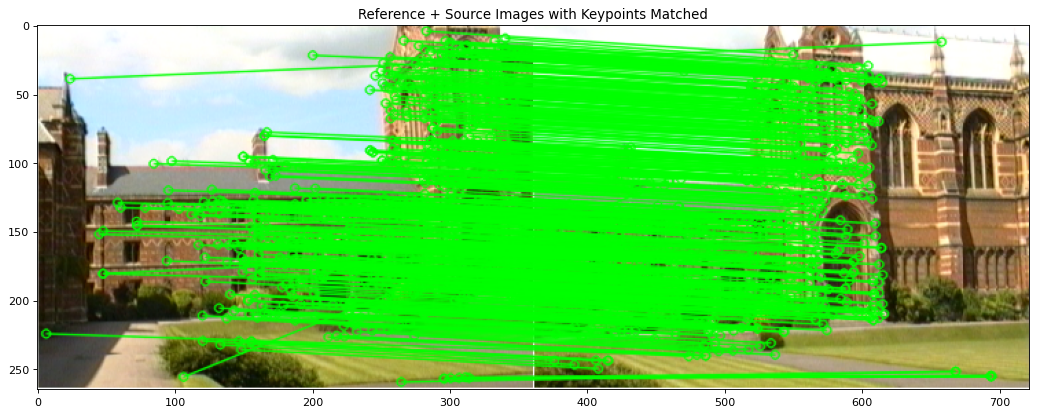

In [6]:
img_matches = cv2.drawMatches(
                img_reference, 
                img_reference_keypoints, 
                img_source, 
                img_source_keypoints,
                good_matches, 
                None,
                matchColor = (0, 255, 0),
                flags = cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize = (16, 9))

plt.title("Reference + Source Images with Keypoints Matched")
plt.imshow(img_matches);

**Step 4: Compute the Homography Matrix that will transform the source image (B) such that it aligns with the reference image (A). Thereafter, apply this Homography matrix to the source image (B) to obtained the transformed source image (B')**<br>

To perform this step, we'll make use of OpenCV's `findHomography()` function. The syntax is as follows:

`cv2.findHomography(srcPoints, dstPoints[method, [ransacReprojThreshold]])`

- **srcPoints**: An array of points from the source image as (x, y) coordinates.
- **dstPoints**: An array of corresponding points from the destination image represented as (x, y) coordinates.
- **method**: The method used to compute the homography matrix.
    - **cv2.RANSAC**: (Default Value). This is a robust method that uses the RANSAC (Random Sample Consensus) algorithm to estimate the homography matrix while ignoring outliers.
- **ransacReprojThreshold**: This parameter is used with the RANSAC method (cv2.RANSAC). It sets the maximum allowed reprojection error (in pixels) to treat a point pair as an inlier. Increasing this value will produce a more relaxed homography estimation, while decreasing it will make the estimation more strict.

The purpose of the above function is to find the transformation matrix (a.k.a the homography matrix) that will transform the points from one perspective (that of the source image) to another perspective (that of the destination image).

The reason we're using it is because we would like to transform/align our source image (B) to our destination image (A).

Now as per the function requirments, we require srcPoints and dstPoints, each of which is a set of coordinates. Let's tackle that first.

Our srcPoints will contain coordinates from our source image (B). Likewise, our dstPoints will contain coordinates from our reference image (A). We'll take these coordinates from the computed keypoints for each image. Remember, that each `KeyPoint` object encapsulates the coordinates of it's respective keypoint in the `pt` attribute.

In [7]:
img_reference_coordinates = []

for keypoint in img_reference_keypoints:
    img_reference_coordinates.append(keypoint.pt)

img_source_coordinates = []

for keypoint in img_source_keypoints:
    img_source_coordinates.append(keypoint.pt)

## Alternatively, make use of list comprehensiion
img_reference_coordinates = [keypoint.pt for keypoint in img_reference_keypoints]
img_source_coordinates = [keypoint.pt for keypoint in img_source_keypoints]

Now we have the coordinates, but they do not correspond to one another. We simply took the coordinates from the keypoints of each respective image. 

We'll be using the `good_matches` list to find a list of corresponding coordinates. Remember that `good_matches` consists of `DMatch` objects where each `DMatch` object contain the index of the keypoint from the first image (stored in queryIdx) and the **corresponding** keypoint in the second image (stored in trainIdx). We'll make use of this to correspond the coordinates to one another.

In [8]:
srcPoints = []
dstPoints = []

for match in good_matches:

    index_of_keypoint_in_first_image = match.queryIdx; # return the index of the keypoint in the first image
    index_of_corresponding_keypoint_in_second_image = match.trainIdx; # return the index of the corresponding keypoint in the second image
    
    srcPoint = img_source_coordinates[index_of_corresponding_keypoint_in_second_image] # save the coordinates of the keypoint
    dstPoint = img_reference_coordinates[index_of_keypoint_in_first_image] # save the coordinate of the corresponding keypoint

    srcPoints.append(srcPoint) # add the coordinate to the source list
    dstPoints.append(dstPoint) # add the cooresponding coordinate to the destination list

srcPoints = np.array(srcPoints)
dstPoints = np.array(dstPoints)

We can now employ the `cv2.findHomography()` function. But first, it's important to note that not all the matches we obtained form KNN + Ratio Test were accurate. This will have a negative effect when calculating the homography matrix as the same transformation matrix cannot satisfy both accurately matched coordinates and wrong coordinates. 

For this reason, we need some way of filtering out outliers in our coordinates when computing the trasnformation matrix. This is achieved by using the RANSAC algorithm. You can read more about it [here](https://youtu.be/EkYXjmiolBg?si=qOtD5A-OaxXVfNRo). 

Thankfully, this is not a separate step we need to apply. The `cv2.findHomography()` method will automatically apply the RANSAC algorithm for us.

In [9]:
(homography_matrix, status) = cv2.findHomography(srcPoints, dstPoints, method = cv2.RANSAC, ransacReprojThreshold = 8)

As you can see, the function call returns two entities. The first is the transformation matrix and the latter is a list that indicates what pairs of corresponding points were used at inliers during the RANSAC estimation.

You can view the homography matrix as well:

In [10]:
homography_matrix

array([[ 9.04984403e-01,  3.58737928e-02,  9.70658837e+01],
       [-5.79812671e-02,  9.73586898e-01, -5.46056767e+00],
       [-2.68800981e-04,  4.58922877e-05,  1.00000000e+00]])

Because it is a $3 \times 3$ matrix, we'll make use of the `warpPerspective()` transformation.

In [11]:
height, width = img_source.shape[:2]

result = cv2.warpPerspective(img_source, homography_matrix, dsize = (width + width, height + height))

If you would like to see the transformation source image (B'), you may do so:

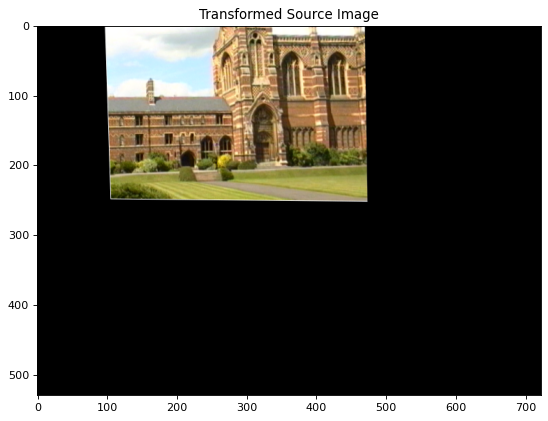

In [12]:
plt.figure(figsize = (12, 6))

plt.title("Transformed Source Image")
plt.imshow(result);

**Step 5: Display a new image that concatenates the reference image (A) and the transformed source image (B').**

Finally, we'll overlay the reference image on top of the transformed source image.

In [13]:
height, width = img_reference.shape[:2]

result[0:height, 0:width] = img_reference 

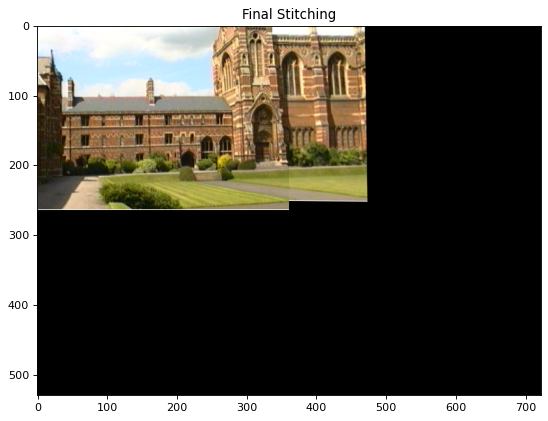

In [14]:
plt.figure(figsize = (12, 6))

plt.title("Final Stitching")
plt.imshow(result);

You can adjust the output as desired:

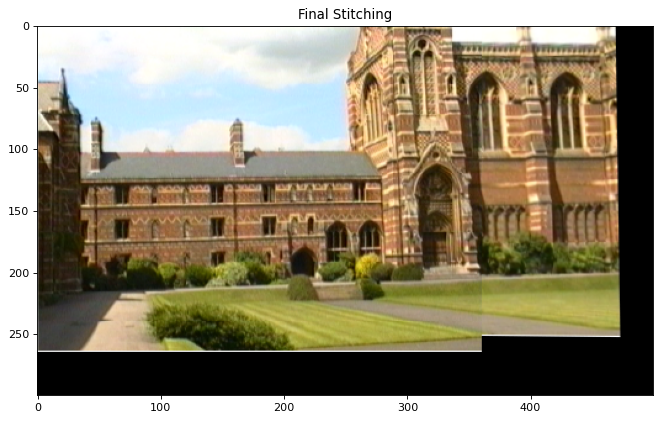

In [15]:
plt.figure(figsize = (12, 6))

plt.title("Final Stitching")
plt.imshow(result[:300,:500]);